In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import pymysql
import yfinance as yf
import talib
import numpy as np

In [220]:
# acquiring data
ticker = 'MCD'
price = yf.download(ticker, start='2015-04-22', end='2020-02-14')

[*********************100%***********************]  1 of 1 completed


In [221]:
price.rename(columns={'Adj Close':'Adj_Close'}, inplace=True)

In [222]:
# close price
close = price['Adj_Close'].values

In [223]:
# calculate indicators
up, mid, low = talib.BBANDS(close, timeperiod = 20)
rsi = talib.RSI(close, timeperiod=14)
price['RSI'] = rsi
price['Upper_BB'] = up
price['Mid_BB'] = mid
price['Lower_BB'] = low

In [224]:
# calculate B% souce:https://www.tradingview.com/wiki/Bollinger_Bands_%25B_(%25B)
def bb_pct(price):
    up, mid, low = talib.BBANDS(close, timeperiod=20)
    bbp = (price-low)/(up -low)
    return bbp
price['BBands_Pct'] = bb_pct(price['Adj_Close'])

In [225]:
# create a column to indicate buy and sell actions for the simple strategy
actions = []
for i in price.itertuples():
    bbp = i.BBands_Pct
    rsi = i.RSI
    current_holdings = sum(actions)
    if bbp<0 and rsi<30 and current_holdings==0:
        actions.append(1)
    elif bbp>1 and rsi>70 and current_holdings==1:
        actions.append(-1)
    else:
        actions.append(0)
price['Actions'] = actions

In [229]:
# calculate daily percentage change
price['Pct_Change'] = 0
# buy sell period
buy_date = price[price['Actions']==1].index
sell_date = price[price['Actions']==-1].index
#calculate return between buy sell period
for b, s in zip(buy_date, sell_date):
    price.loc[str(b):str(s), 'Pct_Change'] = price.loc[str(b):str(s), 'Adj_Close'].pct_change().values
#fillna to facilitate the calculation of cumulative portfolio value
price['Pct_Change'].fillna(0, inplace=True)

#calculate portfolio value
cumulative_value = [1000000]
for pct in price['Pct_Change']:
    prior_value = cumulative_value[-1]
    cumulative_value.append(prior_value * (1+pct))
price['Portfolio_Value'] = cumulative_value[1:]

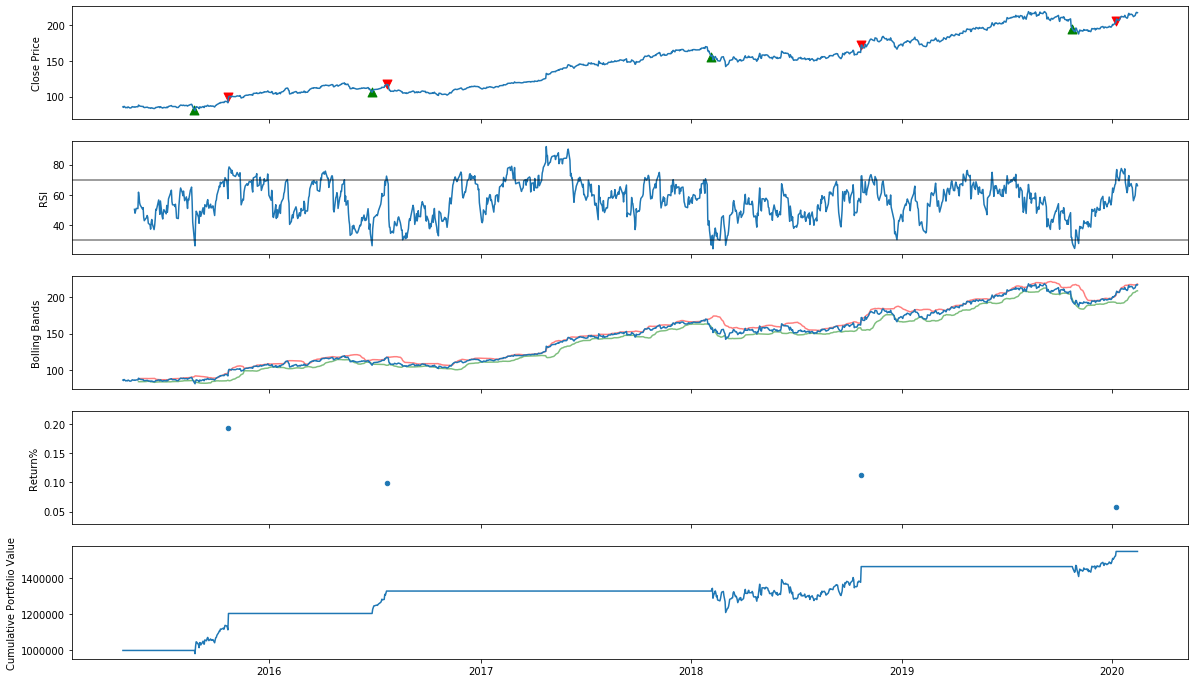

In [237]:
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, figsize=(20, 12), sharex=True)
ax0.plot(price.index, price['Adj_Close'])
ax0.set_ylabel('Close Price')
# plot buy and sell
for i in price.itertuples():
    if i.Actions > 0:
        ax0.scatter(i.Index, i.Adj_Close, color='green', s=80, marker='^')
    elif i.Actions < 0:
        ax0.scatter(i.Index, i.Adj_Close, color='red', s=80, marker='v')
# plot rsi
ax1.plot(price.index, price['RSI'])
ax1.axhline(y=30, alpha=0.5, color='black')
ax1.axhline(y=70, alpha=0.5, color='black')
ax1.set_ylabel('RSI')
# plot BBANDS
ax2.plot(price.index, price['Upper_BB'], color='red', alpha=0.5)
ax2.plot(price.index, price['Lower_BB'], color='green', alpha=0.5)
ax2.plot(price.index, price['Adj_Close'])
ax2.set_ylabel('Bolling Bands')
# plot single trade return
returns = []
for b, s in zip(buy_date, sell_date):
    trade_return = price.loc[str(b): str(s), 'Pct_Change'].sum()
    returns.append(trade_return)
ax3.scatter(price[price['Actions']==-1].index, returns, s=80, marker='.')
ax3.set_ylabel('Return%')
# plot portfolio value
ax4.plot(price.index, price['Portfolio_Value'])
ax4.set_ylabel('Cumulative Portfolio Value');